# Figure S3

In [1]:
library(data.table)
library(ggplot2)
library(stringr)
library(tidyplots)
library(ggpubr)
library(patchwork)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:tidyplots’:

    gene_expression




In [2]:
library('Cairo')
CairoFonts(
regular="Sans:style=Light",
bold="Sans:style=Bold",
italic="Sans:style=Oblique",
bolditalic="Sans:style=BoldOblique"
)

## APA qPCR-PCR data

In [3]:
apa_qpcr = fread("Fig_s3_apa_qRT-PCR_quantitation_combined.csv")

In [4]:
unique(apa_qpcr$variable)

[1] "SFPQ_long_short" "NEFL_long_short" "ELP1_long_short"

### RNA-seq DESeq2 count data

>from data/Zeng_2023_TDP43-7D-KD-RNA-seq

In [5]:
DESeq2_counts = fread("Fig_s3_TDP-43-7D-KD-RNA-seq-DESeq2-gene-normalized-counts.csv")

In [6]:
DESeq2_selected_targets = DESeq2_counts[gene_name %in% c("NEFL","TMEM106B","ELP1")]

In [7]:
DESeq2_selected_targets = melt(DESeq2_selected_targets[, -c(1)], id.vars = "gene_name")

In [8]:
DESeq2_selected_targets[, condition := ifelse(variable %like% "Scr", "Control", "TDP-43 KD")]

In [11]:
## make adjusted p value table for plotting
DESeq2_rlt = fread("Fig_s3_TDP-43-7D-KD-RNA-seq-DESeq2-gene-result-LFC.csv")

In [12]:
DESeq2_padj = DESeq2_rlt[gene_name %in% c("NEFL","TMEM106B","ELP1"), .(gene_name, padj)]

In [13]:
DESeq2_padj[, group1 := "Control"]
DESeq2_padj[, group2 := "TDP-43 KD"]

In [14]:
setnames(DESeq2_padj, "padj", "p.adj")

In [15]:
DESeq2_padj = DESeq2_padj[, .(group1, group2, p.adj, gene_name)]

## Fig. S3a, ELP1 APA

✔ save_plot: saved to fig_s3a_TDP43-7D-KD-ELP1-apa-qRT-PCR-plot.pdf



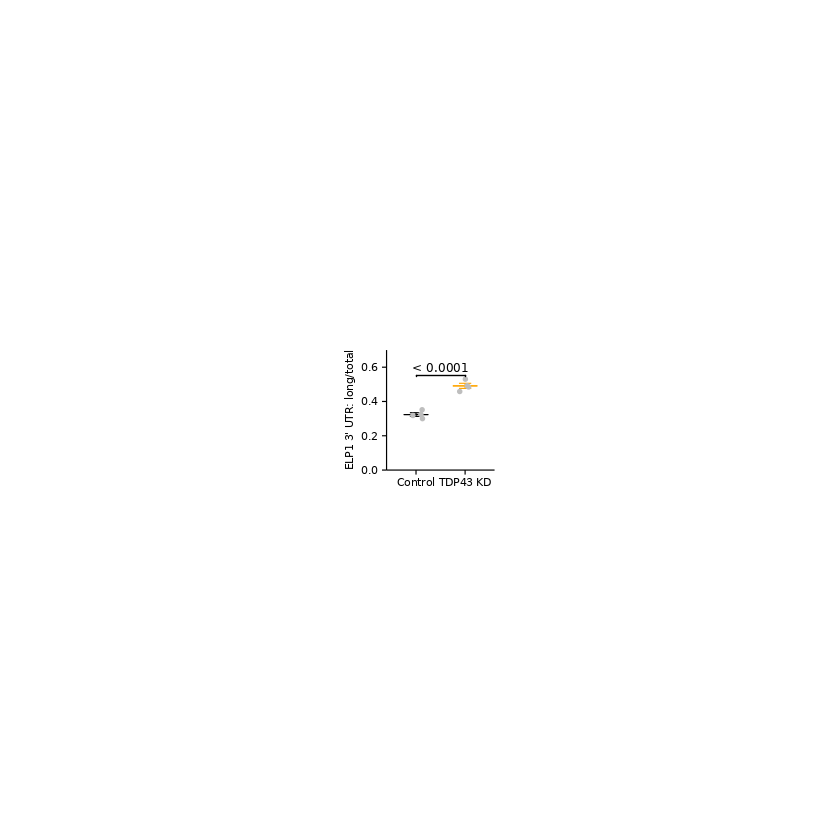

In [16]:
apa_qpcr[variable == "ELP1_long_short"] |>
    tidyplot(x = Sample, y = value, color = Sample) |>
    add_mean_dash(width = 0.5) |>
    add_sem_errorbar(width = 0.25) |>
    add_data_points_jitter(jitter_width = 0.3, size = 0.5, color = "gray") |>
    add_test_pvalue(hide_info = TRUE, 
                    method = "t_test",
                    method.args = list(alternative = "less")) |>
    adjust_colors(new_colors = c("black", "orange")) |> 
    remove_x_axis_title() |>
    adjust_y_axis(title = "ELP1 3' UTR: long/total",
                  limits = c(0, 0.7), breaks = c(0, 0.2, 0.4, 0.6)) |>
    remove_legend() |>
    adjust_size(width = 0.9, height = 1, unit = "in") |>
    adjust_font(fontsize = 6) |>
    save_plot("fig_s3a_TDP43-7D-KD-ELP1-apa-qRT-PCR-plot.pdf", 
              view_plot = TRUE,
              bg = "transparent",
              dpi = 300)

## Fig. S3b, ELP1 targeted APA across cell lines

In [17]:
elp1_apa = fread("fig_s3b_ELP1_APA_across_samples.csv")

In [18]:
unique(elp1_apa$condition)

[1] "positive"   "negative"   "Scramble"   "TDP43KD"    "TDP43WT"   
[6] "TDP43K263E" "scramble"   "KD"         "control"

In [19]:
elp1_apa[condition %in% c("Scramble", "scramble", "control", "positive", "TDP43WT"), condition := "Control"]
elp1_apa[condition %in% c("TDP43KD", "KD", "TDP43KD", "negative", "TDP43K263E"), condition := "Mutant"]

In [20]:
unique(elp1_apa$condition)

[1] "Control" "Mutant"

In [21]:
elp1_apa$condition = factor(elp1_apa$condition, levels = c("Control", "Mutant"))

In [22]:
unique(elp1_apa$study)

[1] "Liu_2019" "Inhouse"  "Imaizumi" "Klim"     "sh-sy5y"  "sknz"

In [23]:
elp1_apa$study = factor(elp1_apa$study, levels = c("Liu_2019", "Inhouse", "Imaizumi", "Klim", "sh-sy5y", "sknz"))

In [24]:
elp1_apa_stat_test <- elp1_apa %>%
  group_by(study) %>%
  rstatix::t_test(normalized_value ~ condition, alternative = "less") %>%
  rstatix::add_significance() %>% 
  rstatix::add_xy_position(x = "condition")

In [25]:
unique(elp1_apa$study)

[1] Liu_2019 Inhouse  Imaizumi Klim     sh-sy5y  sknz    
Levels: Liu_2019 Inhouse Imaizumi Klim sh-sy5y sknz

In [30]:
elp_apa_facet_label <- c(
  Liu_2019 = "Liu (FTD brain)",
  Inhouse  = "In-house (iNeuron)",
  Imaizumi = "IMaizumi (iNeuron)",
  Klim     = "Klim (iMN)",
  `sh-sy5y` = "Brown (SH-SY5Y)",
  sknz     = "Brown (SKNZ)"
)

In [31]:
fig_s3b = ggplot(elp1_apa, aes(condition, normalized_value, color = condition)) + 
    geom_jitter(width = 0.3, size = 0.2, show.legend = F, color = "gray") + 
    stat_summary(fun.data = "mean_se",
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.3,
                 show.legend = F) +
    stat_summary(fun = mean,
                 fun.min = mean,
                 fun.max = mean,
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.5,
                 show.legend = F) +
    facet_wrap(~study, nrow = 1, scales = c("free"), 
               labeller = as_labeller(elp_apa_facet_label)) +
    stat_pvalue_manual(elp1_apa_stat_test, label = "p", size = 7/.pt) +
    #stat_compare_means(label = "p.signif", size = 4, method = "t.test", method.args = list(alternative = "greater"), show.legend = F) +
    scale_x_discrete(name = NULL) +
    scale_y_continuous(name = "Normalized dPUR") +
    scale_color_manual(values = c("black","orange")) +
    theme_classic(base_size = 7) + 
    theme(strip.background = element_blank())

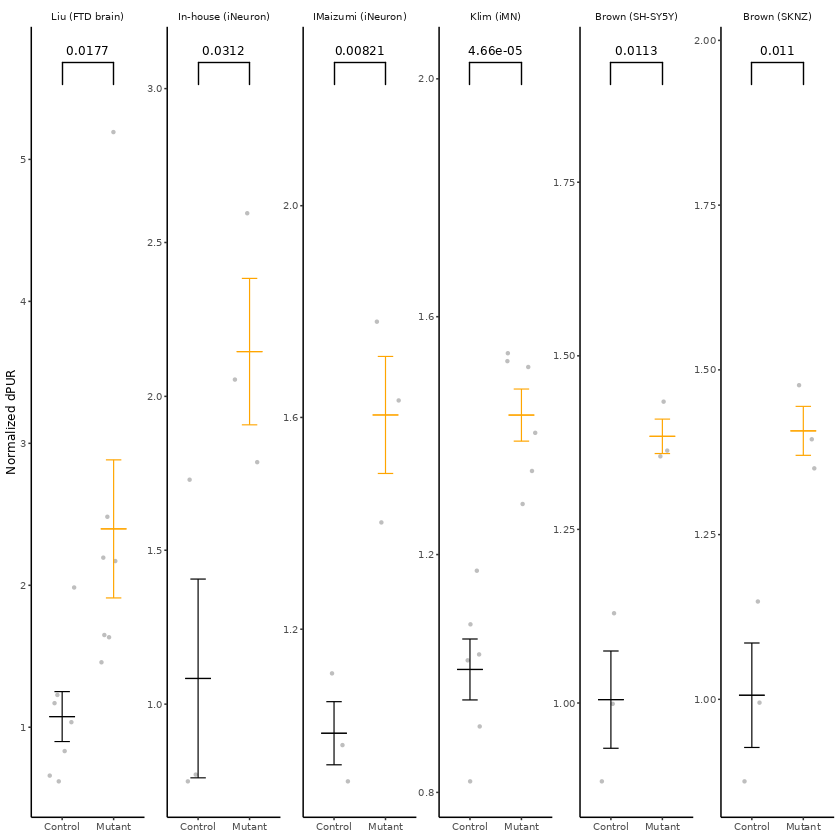

In [32]:
fig_s3b

In [33]:
## further formatted in illustrator for visualization and labeling purpose only
ggsave(filename = "fig_s3b_elp1_apa_across_samples_plot.pdf",fig_s3b, width = 5, height = 1, units = "in")

## Fig. S3c, ELP1 RNA levels from RNA-seq

In [34]:
ELP1_padj = DESeq2_padj[gene_name == "ELP1"]
ELP1_padj[, y.position := max(DESeq2_selected_targets[gene_name == "ELP1"]$value)*1.05]

In [35]:
fig_s3c = ggplot(DESeq2_selected_targets[gene_name == "ELP1"], aes(condition, value, color = condition)) + 
    geom_jitter(width = 0.3, size = 0.2, show.legend = F, color = "gray") + 
    stat_summary(fun.data = "mean_se",
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.3,
                 show.legend = F) +
    stat_summary(fun = mean,
                 fun.min = mean,
                 fun.max = mean,
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.5,
                 show.legend = F) +
    ggpubr::stat_pvalue_manual(ELP1_padj, label = "p.adj", size = 7/.pt) +
    scale_x_discrete(name = NULL) +
    scale_y_continuous(name = "ELP1 RNA level\n(TPM, x1,000)", 
                       limits = c(0, 12000), 
                       labels = scales::label_number(scale = 1/1000)) +
    scale_color_manual(values = c("black","orange", "black","orange")) +
    theme_classic(base_size = 7)

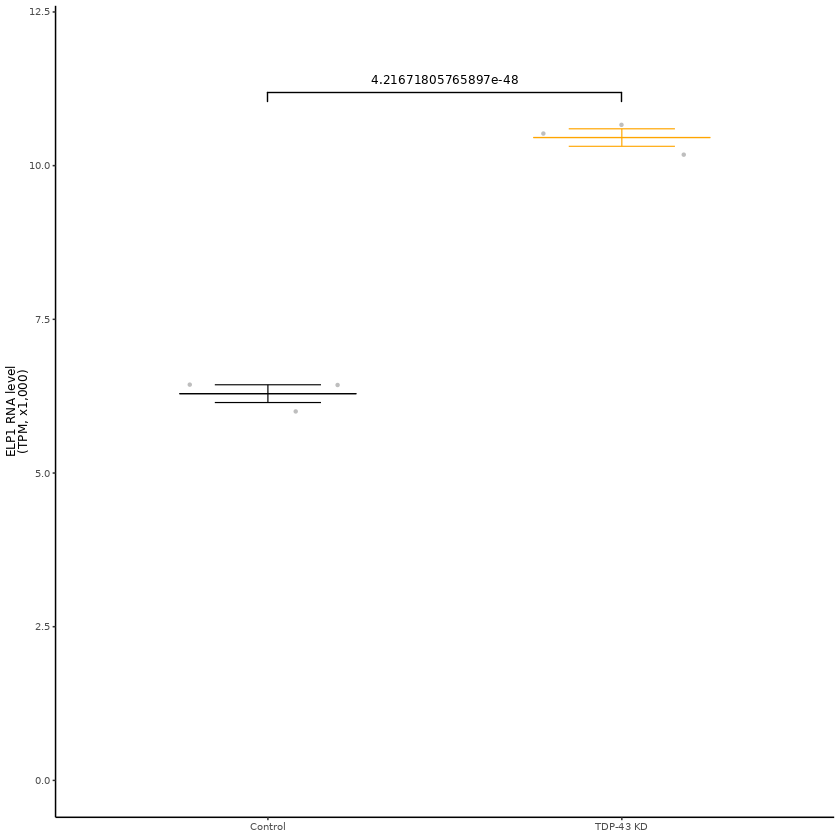

In [36]:
fig_s3c

In [37]:
ggsave(fig_s3c, 
       filename = "fig_s3c_TDP43-7D-KD-ELP1-RNA-level-plot.pdf", 
       width = 1.4,
       height = 1.25,
       units = "in",
       bg = "transparent",
       dpi = 300)

## Fig. S3d, ELP3 WB quantitation

In [38]:
ELP3_WB = fread("Fig_s3d_TDP43-7d-KD_ELP3-WB-quantitation.csv")

✔ save_plot: saved to fig_s3d_TDP43-7D-KD-ELP3-WB-quantitation-plot.pdf



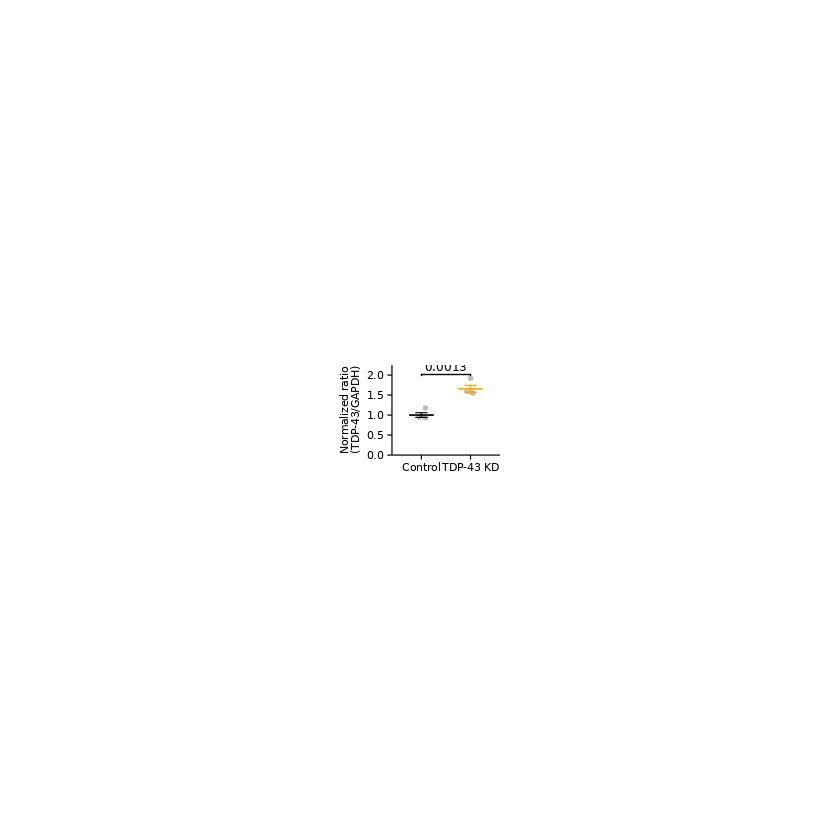

In [40]:
ELP3_WB |>
    tidyplot(x = Sample, y = normalized_ratio, color = Sample) |>
    add_data_points_jitter(jitter_width = 0.2, size = 0.5, color = "gray") |>
    add_mean_dash(width = 0.5) |>
    add_sem_errorbar(width = 0.25) |>
    add_test_pvalue(hide_info = TRUE) |>
    remove_x_axis_title() |>
    adjust_y_axis(title = "Normalized ratio\n(TDP-43/GAPDH)", limits = c(0, 2.25)) |>
    adjust_colors(new_colors = c("black", "orange")) |> 
    remove_legend() |>
    adjust_size(width = 0.9, height = 0.75, unit = "in") |>
    adjust_font(fontsize = 6) |>
    save_plot("fig_s3d_TDP43-7D-KD-ELP3-WB-quantitation-plot.pdf", 
              view_plot = TRUE,
              bg = "transparent",
              dpi = 300)

## Fig. S3f, NEFL RNA levels from RNA-seq

In [41]:
NEFL_padj = DESeq2_padj[gene_name == "NEFL"]
NEFL_padj[, y.position := max(DESeq2_selected_targets[gene_name == "NEFL"]$value)*1.05]

In [42]:
fig_s3f = ggplot(DESeq2_selected_targets[gene_name == "NEFL"], aes(condition, value, color = condition)) + 
    geom_jitter(width = 0.3, size = 0.2, show.legend = F, color = "gray") + 
    stat_summary(fun.data = "mean_se",
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.3,
                 show.legend = F) +
    stat_summary(fun = mean,
                 fun.min = mean,
                 fun.max = mean,
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.5,
                 show.legend = F) +
    ggpubr::stat_pvalue_manual(NEFL_padj, label = "p.adj", size = 6/.pt) +
    scale_x_discrete(name = NULL) +
    scale_y_continuous(name = "NEFL RNA level\n(TPM, x1,000)", 
                       limits = c(0, 700000), 
                       labels = scales::label_number(scale = 1/1000)) +
    scale_color_manual(values = c("black","orange", "black","orange")) +
    theme_classic(base_size = 7)

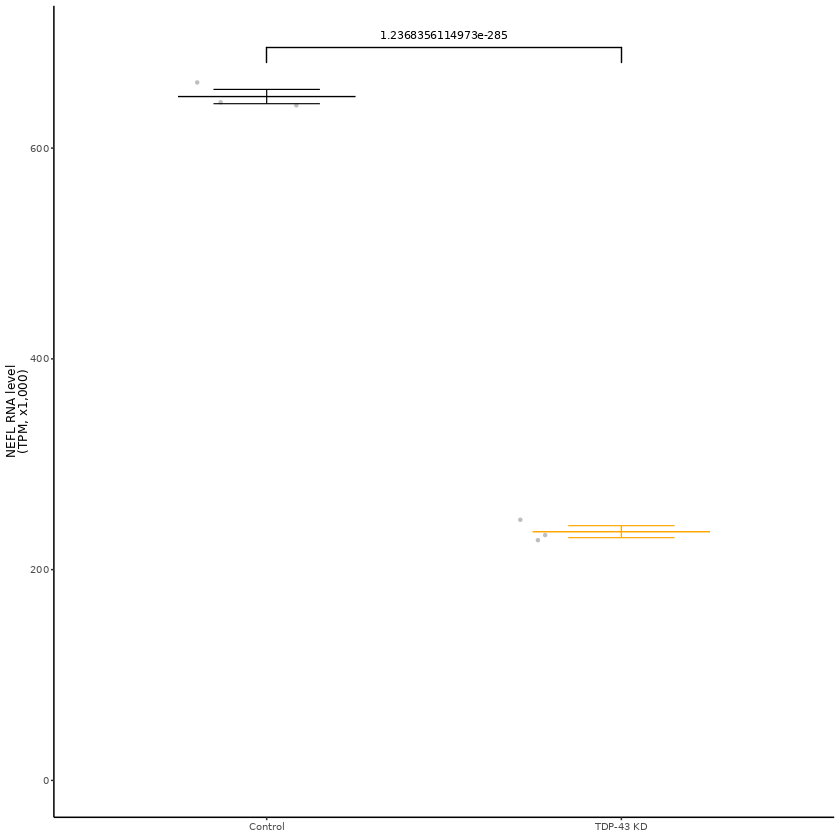

In [43]:
fig_s3f

In [44]:
ggsave(fig_s3f, 
       filename = "fig_s3f_TDP43-7D-KD-NEFL-RNA-level-plot.pdf", 
       width = 1.4,
       height = 1.25,
       units = "in",
       bg = "transparent",
       dpi = 300)

## Fig. S3g, NEFL APA

✔ save_plot: saved to fig_s3g_TDP43-7D-KD-NEFL-apa-qRT-PCR-plot.pdf



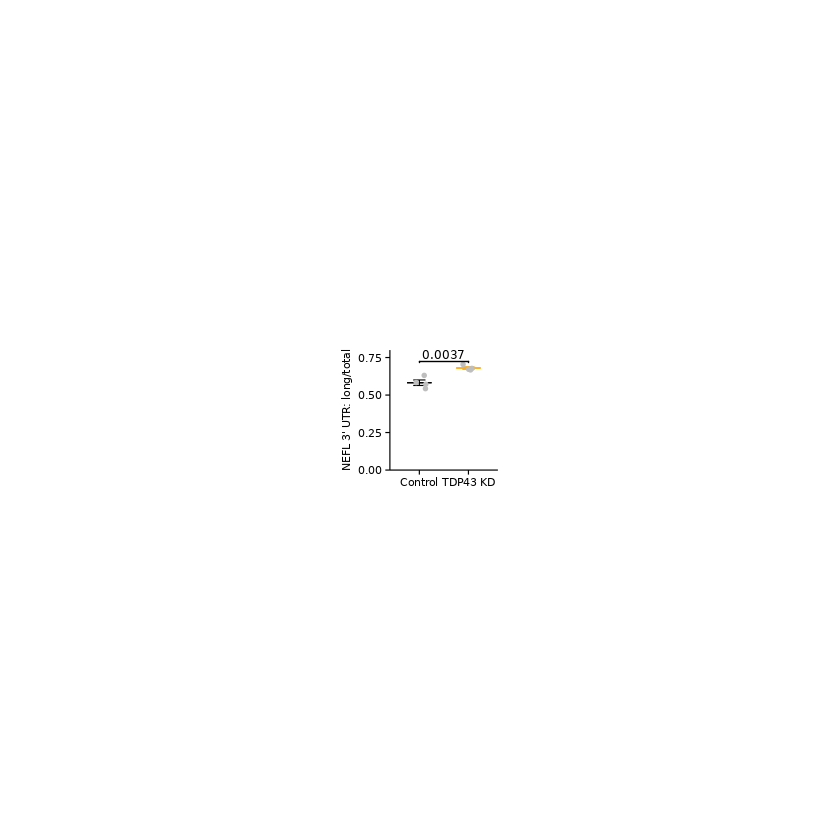

In [45]:
apa_qpcr[variable == "NEFL_long_short"] |>
    tidyplot(x = Sample, y = value, color = Sample) |>
    add_mean_dash(width = 0.5) |>
    add_sem_errorbar(width = 0.25) |>
    add_data_points_jitter(jitter_width = 0.3, size = 0.5, color = "gray") |>
    add_test_pvalue(hide_info = TRUE, 
                       method = "t_test",
                       method.args = list(alternative = "less")) |>
    adjust_colors(new_colors = c("black", "orange")) |> 
    remove_x_axis_title() |>
    adjust_y_axis(title = "NEFL 3' UTR: long/total",
                  limits = c(0, 0.8), breaks = c(0, 0.25, 0.5, 0.75)) |>
    remove_legend() |>
    adjust_size(width = 0.9, height = 1, unit = "in") |>
    adjust_font(fontsize = 6) |>
    save_plot("fig_s3g_TDP43-7D-KD-NEFL-apa-qRT-PCR-plot.pdf", 
              view_plot = TRUE,
              bg = "transparent",
              dpi = 300)

## Fig. S3i, SFPQ APA

✔ save_plot: saved to fig_s3i_TDP43-7D-KD-SFPQ-apa-qRT-PCR-plot.pdf



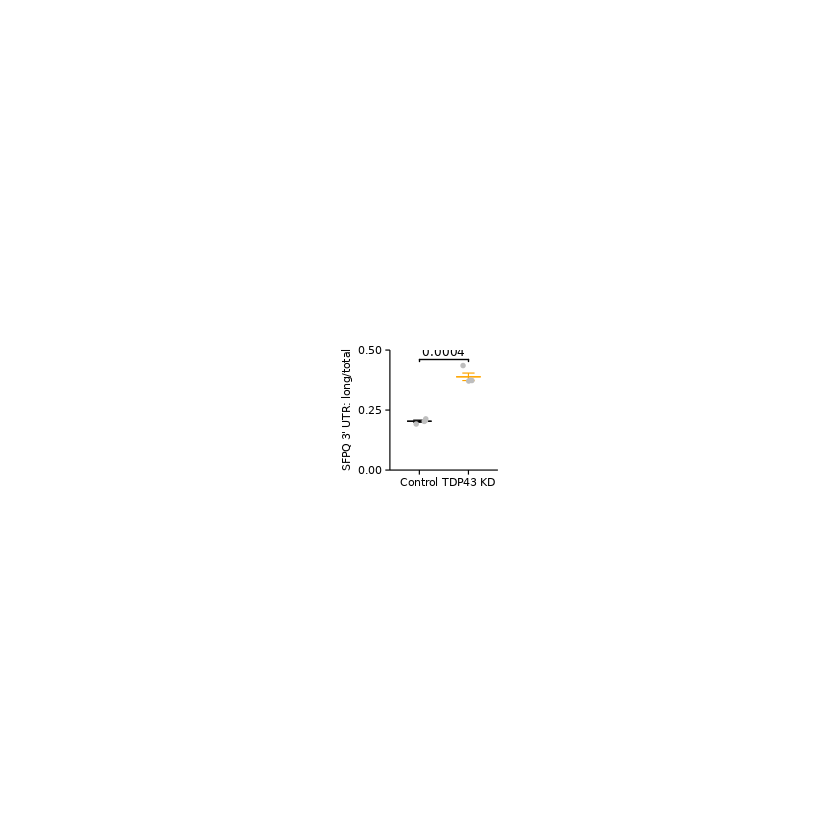

In [46]:
apa_qpcr[variable == "SFPQ_long_short"] |>
    tidyplot(x = Sample, y = value, color = Sample) |>
    add_mean_dash(width = 0.5) |>
    add_sem_errorbar(width = 0.25) |>
    add_data_points_jitter(jitter_width = 0.3, size = 0.5, color = "gray") |>
    add_test_pvalue(hide_info = TRUE, 
                       method = "t_test",
                       method.args = list(alternative = "less")) |>
    adjust_colors(new_colors = c("black", "orange")) |> 
    remove_x_axis_title() |>
    adjust_y_axis(title = "SFPQ 3' UTR: long/total",
                  limits = c(0, 0.5), breaks = c(0, 0.25, 0.5)) |>
    remove_legend() |>
    adjust_size(width = 0.9, height = 1, unit = "in") |>
    adjust_font(fontsize = 6) |>
    save_plot("fig_s3i_TDP43-7D-KD-SFPQ-apa-qRT-PCR-plot.pdf", 
              view_plot = TRUE,
              bg = "transparent",
              dpi = 300)

## Fig. S3j, competition PCR quantitation

In [47]:
sfpq_comp_pcr = fread("fig_s3j_SFPQ_competition_PCR_quantitation.csv")

In [49]:
head(sfpq_comp_pcr)

Sample,normalized_ratio,replicate
<chr>,<dbl>,<int>
Control,0.1465482,1
TDP-43 KD,0.4300993,1
Control,0.1664535,2
TDP-43 KD,0.3666615,2
Control,0.1484448,3
TDP-43 KD,0.3714275,3


✔ save_plot: saved to fig_s3j_TDP43-7D-KD-SFPQ-competition-PCR-plot.pdf



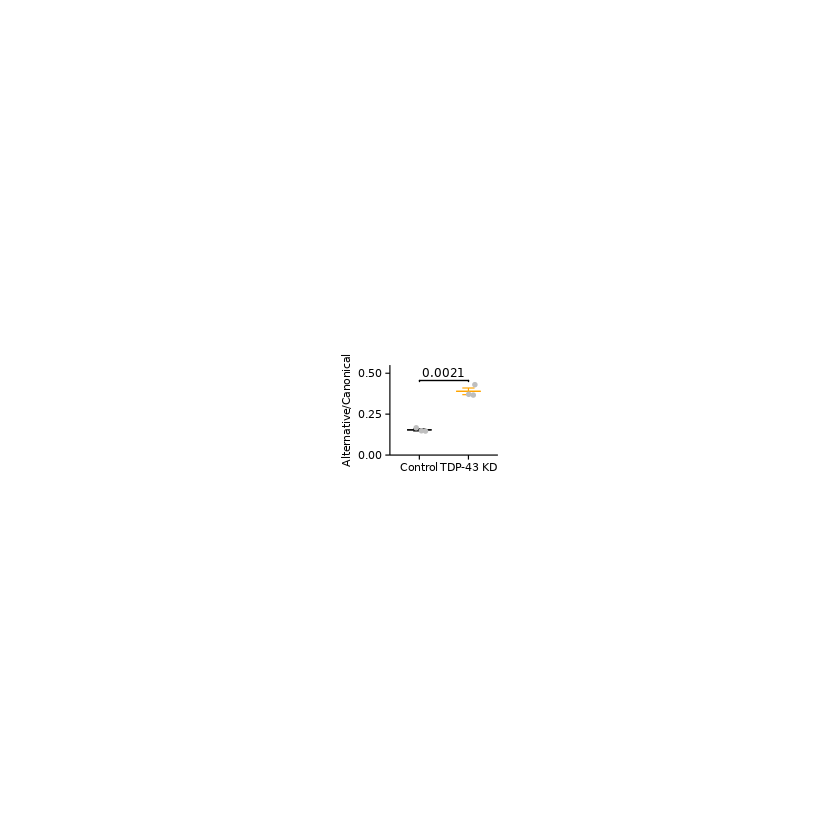

In [50]:
sfpq_comp_pcr |>
    tidyplot(x = Sample, y = normalized_ratio, color = Sample) |>
    add_mean_dash(width = 0.5) |>
    add_sem_errorbar(width = 0.25) |>
    add_data_points_jitter(jitter_width = 0.3, size = 0.5, color = "gray") |>
    add_test_pvalue(hide_info = TRUE, 
                       method = "t_test",
                       method.args = list(alternative = "less")) |>
    adjust_colors(new_colors = c("black", "orange")) |> 
    remove_x_axis_title() |>
    adjust_y_axis(title = "Alternative/Canonical",
                  limits = c(0, 0.55), breaks = c(0, 0.25, 0.5)) |>
    remove_legend() |>
    adjust_size(width = 0.9, height = 0.75, unit = "in") |>
    adjust_font(fontsize = 6) |>
    save_plot("fig_s3j_TDP43-7D-KD-SFPQ-competition-PCR-plot.pdf", 
              view_plot = TRUE,
              bg = "transparent",
              dpi = 300)

## Fig. S3k, pUFP1 quantitatoin upon 11j treatment

In [51]:
pUPF1_wb = fread("Fig_s3k_11j_pUPF1-WB-quantitation.csv")

In [52]:
pUPF1_wb$group = factor(pUPF1_wb$group, levels = c("DMSO", "0.01uM", "0.05uM", "0.1uM","0.5uM", "1uM"))

In [53]:
head(pUPF1_wb)

Sample,group,ratio,normalized_ratio
<chr>,<fct>,<dbl>,<dbl>
DMSO_1,DMSO,4.0246914,1.09437460
DMSO_2,DMSO,3.3305439,0.90562540
1uM_1,1uM,0.1555851,0.04230595
1uM_2,1uM,0.1624606,0.04417549
0.5uM_1,0.5uM,0.1227336,0.03337313
0.5uM_2,0.5uM,0.1017214,0.02765960


In [54]:
fig_s3k_plot = 
    ggplot(pUPF1_wb, aes(group, normalized_ratio)) + 
    geom_jitter(width = 0.3, size = 0.2, show.legend = F, color = "gray") + 
    stat_summary(fun.data = "mean_se",
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.3,
                 show.legend = F) +
    stat_summary(fun = mean,
                 fun.min = mean,
                 fun.max = mean,
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.5,
                 show.legend = F) +
    stat_compare_means(comparisons = list(c("DMSO", "0.01uM"), c("DMSO", "0.05uM"), c("DMSO", "0.1uM"),
                                          c("DMSO", "0.5uM"), c("DMSO", "1uM")),
                       aes(label = after_stat(p)),
                       method = "t.test",
                       method.args = list(alternative = "greater"),
                       size = 7/.pt) +
    scale_x_discrete(name = "11j (µM)", labels = c(0, 0.01, 0.05, 0.1, 0.5, 1.0)) +
    scale_y_continuous(name = "pUPF1/UPF1", limits = c(0, 1.8)) +
    theme_classic(base_size = 7)

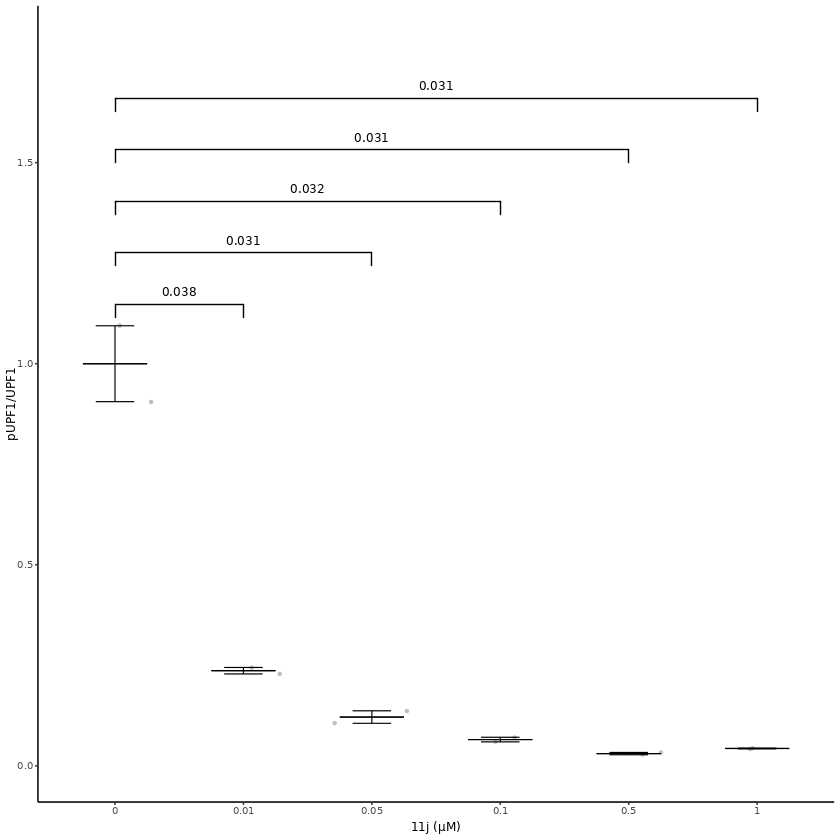

In [55]:
fig_s3k_plot

In [56]:
## reformatted and cleaned up in illustrator
ggsave(fig_s3k_plot, 
       filename = "fig_s3k_pUPF1_11j_wb.pdf", width = 2, height = 1.5, units = "in", bg = "transparent", dpi = 300)

## Fig. S3l, RNA stability

>made in prism

## Fig. S3m, TMEM106B APA

In [57]:
tmem106b_apa = fread("Fig_s3m_TDP43-KD_TMEM106B_apa_qRT-PCR_quantitation.csv")

✔ save_plot: saved to fig_s3m_TDP43-KD-TMEM106B-apa-qRT-PCR-plot.pdf



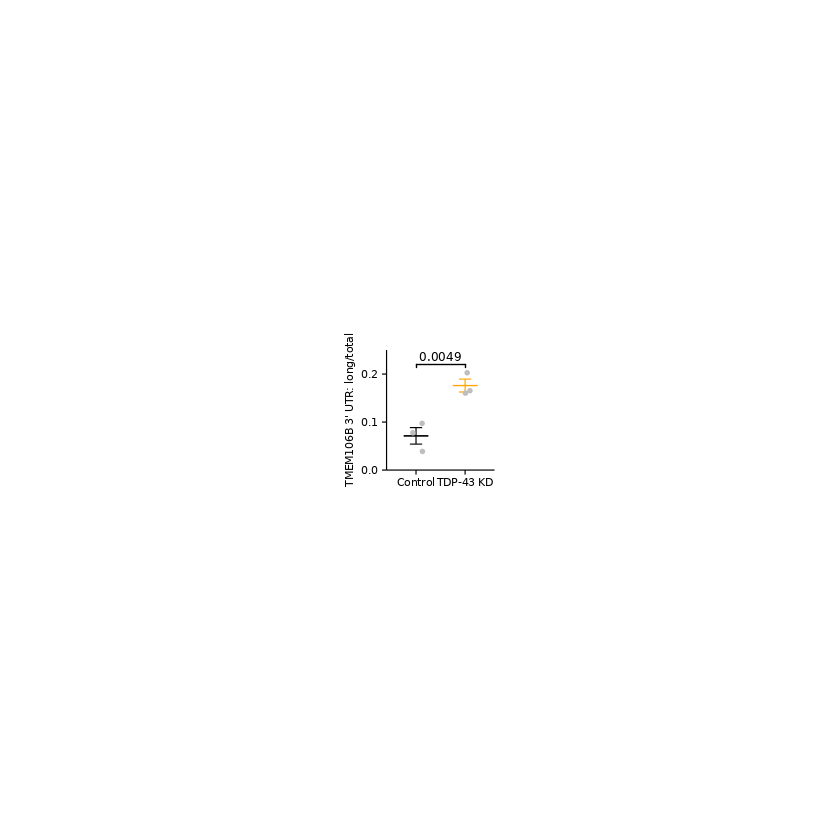

In [58]:
tmem106b_apa |>
    tidyplot(x = Sample, y = value, color = Sample) |>
    add_mean_dash(width = 0.5) |>
    add_sem_errorbar(width = 0.25) |>
    add_data_points_jitter(jitter_width = 0.3, size = 0.5, color = "gray") |>
    add_test_pvalue(hide_info = TRUE, 
                       method = "t_test",
                       method.args = list(alternative = "less")) |>
    adjust_colors(new_colors = c("black", "orange")) |> 
    remove_x_axis_title() |>
    adjust_y_axis(title = "TMEM106B 3' UTR: long/total",
                  limits = c(0, 0.25), breaks = c(0, 0.1, 0.2)) |>
    remove_legend() |>
    adjust_size(width = 0.9, height = 1, unit = "in") |>
    adjust_font(fontsize = 6) |>
    save_plot("fig_s3m_TDP43-KD-TMEM106B-apa-qRT-PCR-plot.pdf", 
              view_plot = TRUE,
              bg = "transparent",
              dpi = 300)

## Fig. S3o, TMEM106B RNA levels from RNA-seq

In [60]:
TMEM106B_padj = DESeq2_padj[gene_name == "TMEM106B"]
TMEM106B_padj[, y.position := max(DESeq2_selected_targets[gene_name == "TMEM106B"]$value)*1.05]

In [61]:
tmem106b_deg = ggplot(DESeq2_selected_targets[gene_name == "TMEM106B"], aes(condition, value, color = condition)) + 
    geom_jitter(width = 0.3, size = 0.2, show.legend = F, color = "gray") + 
    stat_summary(fun.data = "mean_se",
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.3,
                 show.legend = F) +
    stat_summary(fun = mean,
                 fun.min = mean,
                 fun.max = mean,
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.5,
                 show.legend = F) +
    ggpubr::stat_pvalue_manual(TMEM106B_padj, label = "p.adj", size = 5/.pt) +
    scale_x_discrete(name = NULL) +
    scale_y_continuous(name = "TMEM106B RNA level\n(TPM, x1,000)", 
                       limits = c(0, 3500), 
                       labels = scales::label_number(scale = 1/1000)) +
    scale_color_manual(values = c("black","orange", "black","orange")) +
    theme_classic(base_size = 6)

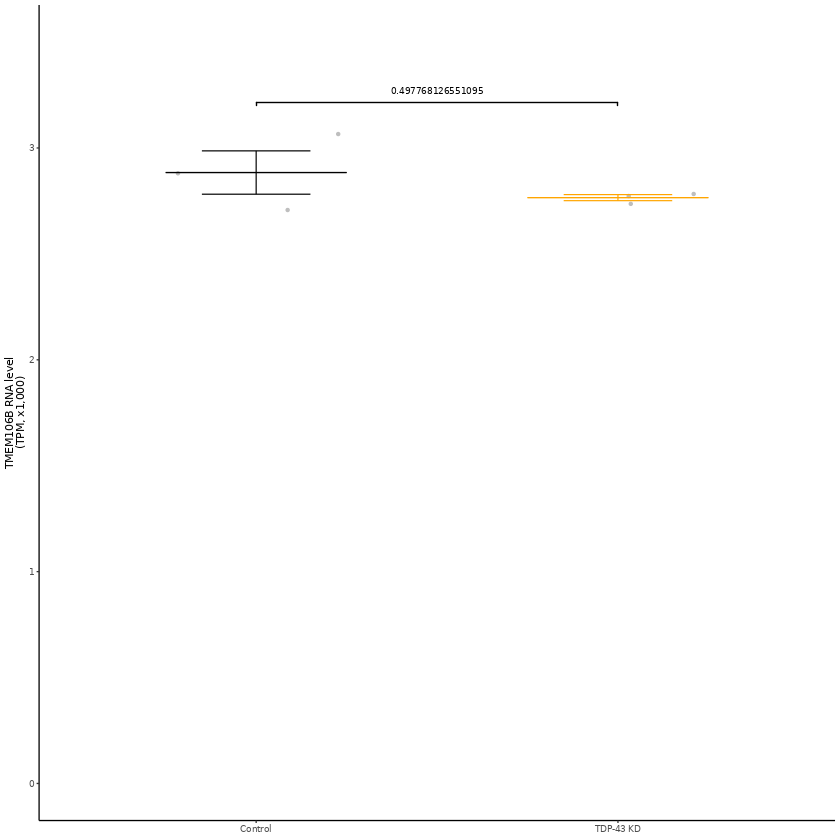

In [62]:
tmem106b_deg

In [63]:
ggsave(tmem106b_deg, 
       filename = "fig_s3o_TDP43-7D-KD-TMEM106B-RNA-level-plot.pdf", 
       width = 1.4,
       height = 1.25,
       units = "in",
       bg = "transparent",
       dpi = 300)

## Fig. S3p, TMEM106B stbility

> made in prsim

## Fig. S3q, luciferase reporter, long 3' UTR RNA levels 

In [65]:
tmem106b_long_3utr_level = fread("Fig_6f_tmem106b_luciferase_RNA_levels.csv")

In [66]:
unique(tmem106b_long_3utr_level$group)

[1] "Long-mut"  "No-insert" "Short"

In [67]:
tmem106b_long_3utr_level$group = factor(tmem106b_long_3utr_level$group, levels = c("No-insert", "Short", "Long-mut"))

In [68]:
#ratio_3utr := 2^(`Cq_mean_Short` - `Cq_mean_Long`)
tmem106b_longer_3utr_level_plot = ggplot(tmem106b_long_3utr_level, aes(group, ratio_3utr, color = group)) + 
    geom_jitter(width = 0.3, size = 0.2, show.legend = F, color = "gray") + 
    stat_summary(fun.data = "mean_se",
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.3,
                 show.legend = F) +
    stat_summary(fun = mean,
                 fun.min = mean,
                 fun.max = mean,
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.5,
                 show.legend = F) +
    stat_compare_means(comparisons = list(c("Short", "Long-mut")),
                       aes(label = after_stat(p)),
                       method = "t.test",
                       method.args = list(alternative = "less"),
                       size = 6/.pt) +
    scale_x_discrete(name = "Long 3' UTR level", labels = c("No insert", "Short", "Long")) +
    scale_y_continuous(name = "Long/total 3' UTR", limits = c(0, 1.8)) +
    scale_color_manual(values = c("gray", "black", "orange")) +
    theme_classic(base_size = 6)

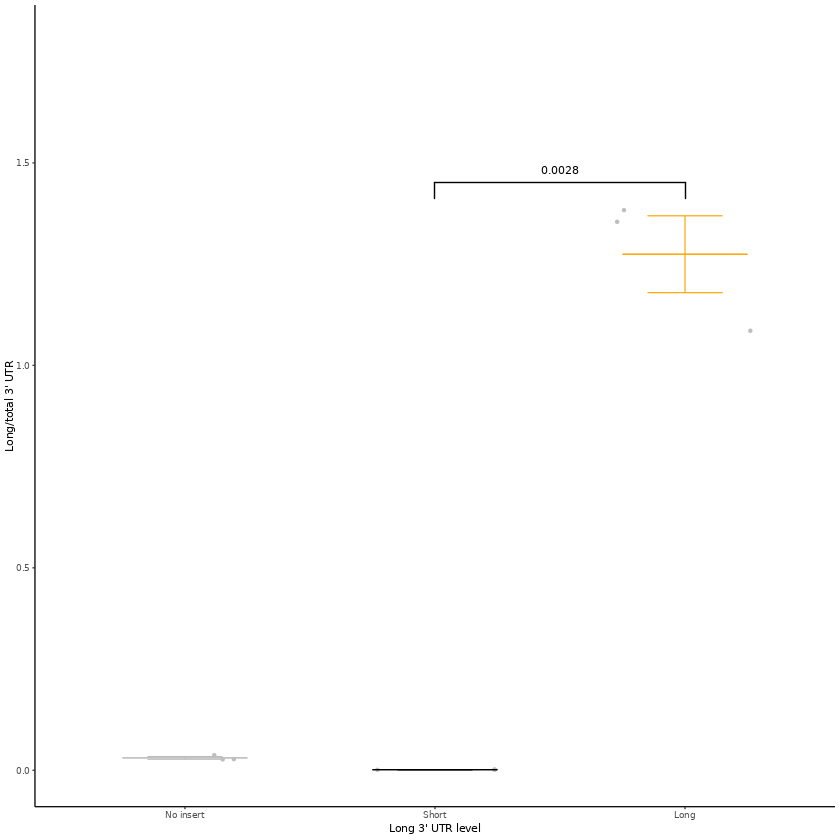

In [69]:
tmem106b_longer_3utr_level_plot

In [70]:
ggsave("fig_s3q.pdf", tmem106b_longer_3utr_level_plot, width = 1.5, height = 1.25, bg = "transparent",dpi = 300)

## Fig. S3r, TMEM106B o/e WB quantitation

In [71]:
tmem106b_oe = fread("Fig_s3r_TMEM106B-OE-WB-quantitation.csv")

In [72]:
unique(tmem106b_oe$Sample)

[1] "En-Dimer"     "Flag-Dimer"   "Flag-Monomer" "TDP-43"

In [73]:
tmem106b_oe$Sample = factor(tmem106b_oe$Sample, levels = c("TDP-43", "En-Dimer", "Flag-Dimer", "Flag-Monomer"))

In [74]:
tmem106b_oe_stat_test <- tmem106b_oe %>%
  group_by(Sample) %>%
  rstatix::t_test(normalized_ratio ~ condition, alternative = "greater") %>%
  rstatix::add_significance() %>% 
  rstatix::add_xy_position(x = "condition")

In [75]:
tmem106b_oe_plot = ggplot(tmem106b_oe, aes(condition, normalized_ratio, color = condition)) + 
    geom_jitter(width = 0.3, size = 0.2, show.legend = F, color = "gray") + 
    stat_summary(fun.data = "mean_se",
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.3,
                 show.legend = F) +
    stat_summary(fun = mean,
                 fun.min = mean,
                 fun.max = mean,
                 geom = "errorbar",
                 linewidth = 0.25,
                 width = 0.5,
                 show.legend = F) +
    facet_wrap(~Sample, nrow = 1, scales = c("free")) +
    stat_pvalue_manual(tmem106b_oe_stat_test, label = "p", size = 6/.pt, y.position = rep(1.35, 4)) +
    scale_x_discrete(name = NULL) +
    scale_y_continuous(name = "Normalized ratio", limits = c(0, 1.4)) +
    scale_color_manual(values = c("black","orange")) +
    theme_classic(base_size = 6) + 
    theme(strip.background = element_blank())

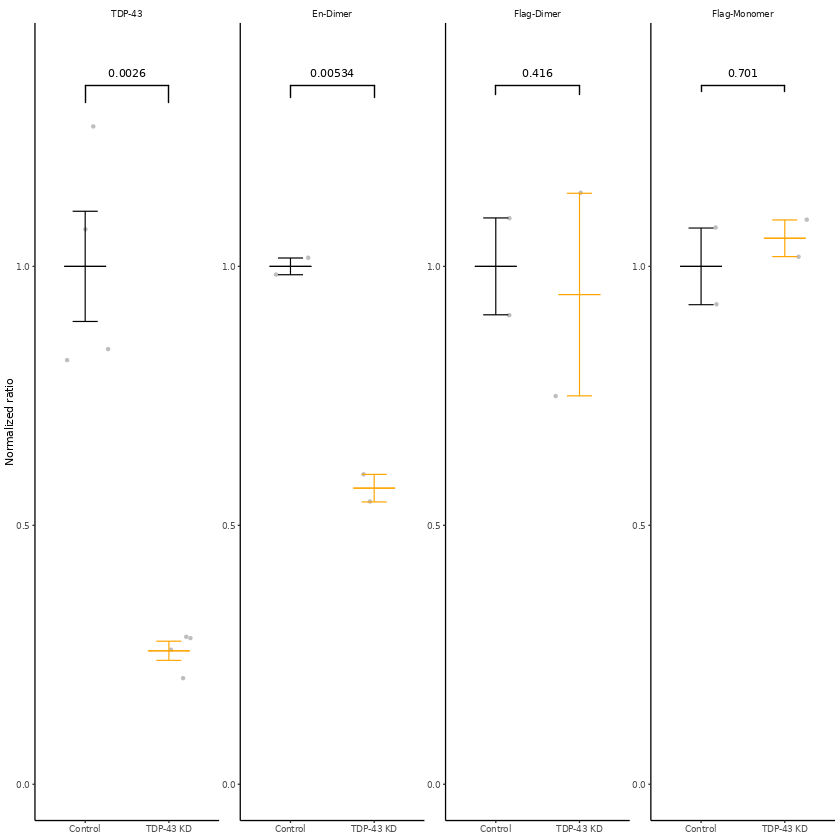

In [76]:
tmem106b_oe_plot

In [77]:
## further formatted in illustrator for visualization and labeling purpose only
ggsave(tmem106b_oe_plot, filename = "fig_s3r_TMEM106B-OE_WB_plot.pdf", height = 1.5, width = 4, units = "in")

In [78]:
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /share/software/user/open/openblas/0.3.10/lib/libopenblas_haswellp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] Cairo_1.6-2       patchwork_1.2.0   ggpubr_0.6.0      tidyplots_0.2.2  
[5] stringr_1.5.1     ggplot2_3.5.0     data.table_1.15.2

loaded via a namespace (and not attached):
 [1] pillar_1.9.0      compiler_4.2.0    base64enc_0.1-3   tools_4.2.0      
 [5] getPass_0.2-4     digest_0.6.3